In [1]:
# 필요한 패키지 호출
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# 데이터 불러오기
data = pd.read_csv('C:/Users/user/Desktop/NIA/CJ/품목별top10도출/강남/gangnam_series.csv')
#data = pd.read_csv('C:/Users/user/Desktop/CJ/gangseo_series.csv')
#data = pd.read_csv('C:/Users/user/Desktop/CJ/songpa_series.csv')

In [3]:
#train/test set 품목별 수동 분할 (현재 상품코드:4658408144)
train_df = data[436:515]
test_df = data[515:537]

print(train_df)
print(test_df)

print("Training Set Shape - ", train_df.shape)
print("Testing Set Shape - ", test_df.shape)

           date  ITEM_QTY          cd
436  2021-03-02         2  4810960248
437  2021-03-03         5  4810960248
438  2021-03-04         5  4810960248
439  2021-03-05        19  4810960248
440  2021-03-08         1  4810960248
..          ...       ...         ...
510  2021-05-27         2  4810960248
511  2021-05-28         7  4810960248
512  2021-05-29         7  4810960248
513  2021-05-30         1  4810960248
514  2021-05-31         5  4810960248

[79 rows x 3 columns]
           date  ITEM_QTY          cd
515  2021-06-01         1  4810960248
516  2021-06-02         2  4810960248
517  2021-06-03         6  4810960248
518  2021-06-04         2  4810960248
519  2021-06-06         1  4810960248
520  2021-06-07         5  4810960248
521  2021-06-08         2  4810960248
522  2021-06-10         5  4810960248
523  2021-06-11         2  4810960248
524  2021-06-15         5  4810960248
525  2021-06-16         3  4810960248
526  2021-06-17         1  4810960248
527  2021-06-18        10  

In [4]:
#SARIMA를 위한 파라미터 자동 분석 후 추천
from pmdarima import auto_arima
stepwise_model = auto_arima(train_df['ITEM_QTY'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=516.816, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=474.760, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=490.025, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=469.881, Time=0.06 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=465.445, Time=0.15 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=463.452, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=461.512, Time=0.06 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=463.450, Time=0.10 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.13 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1

In [8]:
# MODEL FITTING(ARIMA)
# 테이블 : ARIMA (0, 1, 2) 모델을 피팅 한 후 생성 된 요약 테이블
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as sgt

# 모델 정의
model = SARIMAX(train_df["ITEM_QTY"], order = (1, 1, 0))
# 모델 피팅
model_results = model.fit()

In [9]:
# MODEL FITTING(SARIMA)

# 모델정의 
seas_model = SARIMAX(data['ITEM_QTY'], order = (1, 1, 0), seasonal_order = (0, 1, 1, 7))
# 모델피팅
seas_model_results = seas_model.fit()

     lower ITEM_QTY  upper ITEM_QTY  Predictions
515       -7.234101       13.198519     1.901488
516       -7.401853       15.402012     3.649045
517      -10.250813       17.224046     0.521574
518      -11.388843       18.880106     5.109120
519      -13.065203       20.295148     6.100531


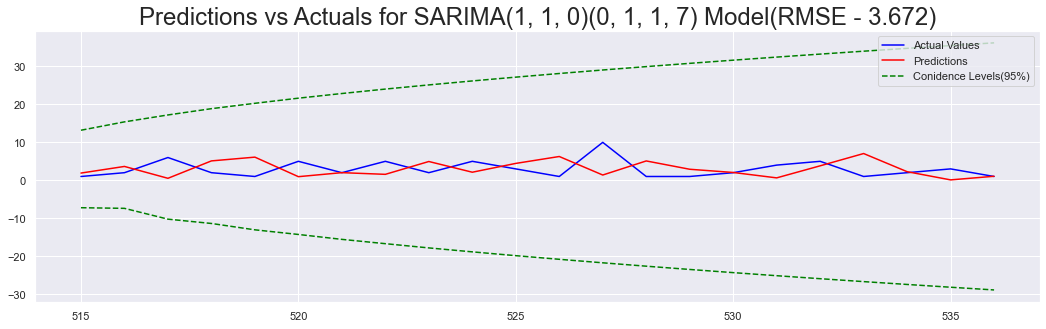

In [10]:
#신뢰구간
# 예측과 신뢰구간
forecasts = model_results.get_forecast(len(test_df.index)) # 예측 객체 생성
forecasts_df = forecasts.conf_int(alpha = 0.05)  # 신뢰구간 95%

# 실제의 예측값
from sklearn.metrics import mean_squared_error
forecasts_df["Predictions"] = seas_model_results.predict (start = test_df.index[0], end = test_df.index[-1])
print(forecasts_df.head()) #orecasts_df
# 예측값 RMSE
sarima_rmse = np.sqrt(mean_squared_error(y_true = test_df["ITEM_QTY"].values, y_pred = forecasts_df["Predictions"].values))
# 예측 신뢰구간 그래프
plt.rcParams["figure.figsize"] = 18, 5

# 테스트셋에서 ITEM_QTY 실제값
plt.plot(test_df["ITEM_QTY"], color = "blue", label = "Actual Values")




# 모델의 예측과 신뢰구간
plt.plot(forecasts_df["Predictions"], color = "red", label = "Predictions")
plt.plot(forecasts_df["upper ITEM_QTY"], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(forecasts_df["lower ITEM_QTY"], color = "green", linestyle = "--")

#그래프 제목 작성 후 도출
plt.title(f"Predictions vs Actuals for SARIMA(1, 1, 0)(0, 1, 1, 7) Model(RMSE - {round(sarima_rmse, 3)})", size = 24)
plt.legend(loc = 'upper right')
plt.show()

In [15]:
forecasts_df1 = forecasts_df[['Predictions']] #Predictions 컬럼만 추출

In [16]:
train_df1 = train_df['ITEM_QTY'] #ITEM_QTY 컬럼만 추출

In [17]:
#모델을 train set에 맞게 조정해 미래 예측
result_seasonal=stepwise_model.fit(train_df1)
print(result_seasonal.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   83
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood                -346.103
Date:                             Tue, 09 Nov 2021   AIC                            700.205
Time:                                     04:44:51   BIC                            709.475
Sample:                                          0   HQIC                           703.906
                                              - 83                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6072      0.119     -5.093      0.000      -0.841      -0.374
ma.L2         -0.3182      

In [18]:
pred_seasonal = result_seasonal.predict(n_periods=7)#향후 7일치 수량 예측


import math
list=[]
sresult = 0

# 7일까지 판매갯수 합을 sresult에 저장
for i in range(0,len(pred_seasonal)):
    sresult = sresult + math.ceil(pred_seasonal[i])

# 7일까지 예측한 정수값을 올림 처리
for i in range(0,len(pred_seasonal)):
    list.append(math.ceil(pred_seasonal[i]))

list#미래 7일 예측 수량

[14, 22, 18, 16, 16, 10, 11]

In [19]:
sresult#미래 7일 예측 총수량

107